In [1]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

In [4]:
def get_latent_theta(adata: ad.AnnData) -> np.ndarray:
    X = adata.obsm['X_latent']
    theta = -np.arctan2(-X[:, 1], X[:, 0]) + np.pi
    return theta

In [2]:
adata = sc.read_h5ad(os.path.join('..', 'data', 'modeling', 'training_latent.h5ad'))
adata

AnnData object with n_obs × n_vars = 140799 × 723
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight'
    obsm: 'X_diff', 'X_diffmap', 'X_latent', 'X_pca', 'X_pca_harmony', 'X_umap', 'velocity_umap'


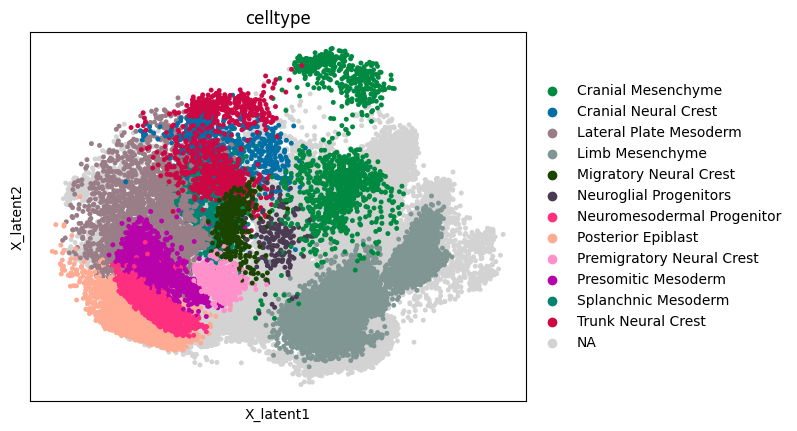

In [3]:
ms = 50
traj_celltype = adata[adata.obs.trajectory].obs.celltype.unique()
sc.pl.embedding(adata, 'X_latent', color = 'celltype', groups = traj_celltype, size = ms, show = False)
plt.gca().invert_yaxis()
plt.show()

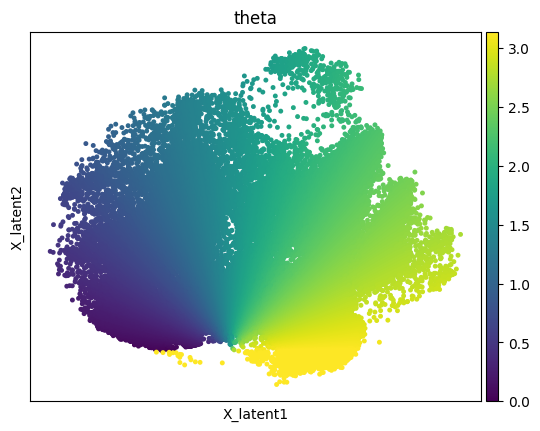

In [5]:
adata.obs['theta'] = get_latent_theta(adata)
sc.pl.embedding(adata, 'X_latent', color = 'theta', size = ms, show = False,
                cmap = 'viridis', vmin = 0, vmax = np.pi)
plt.gca().invert_yaxis()
plt.show()

/tmp/ipykernel_84667/1398033248.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  theta_df = adata.obs.groupby('celltype').theta.mean().sort_values()


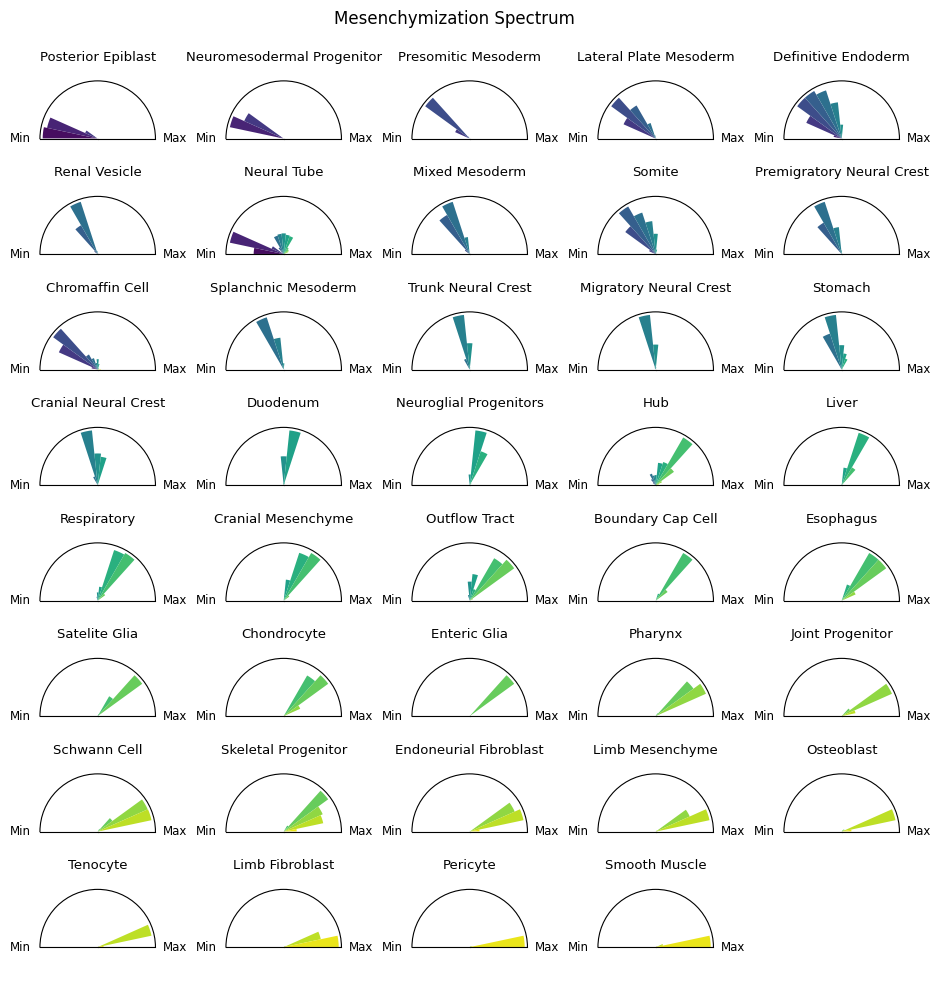

In [6]:
from matplotlib.colors import Normalize

n_bins, theta_lim = 15, [0, np.pi]
bins = np.linspace(*theta_lim, n_bins + 1)
locs = (bins[:-1] + bins[1:]) / 2
widths = np.diff(bins)
cmap = plt.cm.viridis
norm = Normalize(*theta_lim)
colors = [cmap(norm(l)) for l in locs]

theta_df = adata.obs.groupby('celltype').theta.mean().sort_values()
msk_neuron = ~theta_df.index.str.contains('Neuron')
msk_ecto = ~theta_df.index.str.contains('Ectoderm')
theta_df = theta_df.loc[msk_neuron & msk_ecto]

ncol = 5; nrow = theta_df.size // ncol + 1
fig, ax = plt.subplots(nrow, ncol, figsize = (12, 12), subplot_kw = {'projection' : 'polar'})
for i in range(theta_df.size):
    row_i, col_i = i // ncol, i % ncol
    ax_i = ax[row_i, col_i]
    celltype_i = theta_df.index[i]
    msk_i = adata.obs.celltype.isin([celltype_i])
    theta_i = adata[msk_i].obs.theta.values
    counts_i, _ = np.histogram(theta_i, bins = bins)
    bars_i = ax_i.bar(locs, counts_i, width = widths, bottom = 0)

    for b, c in zip(bars_i, colors):
        b.set_facecolor(c)
    
    ax_i.set_theta_zero_location('W')
    ax_i.set_theta_direction(-1)
    ax_i.set_thetamin(0)
    ax_i.set_thetamax(180)

    ax_i.set_yticks([])
    ax_i.set_xticks([0, np.pi], ['Min', 'Max'], fontsize = 8.5)
    ax_i.set_title(celltype_i, y = .85, size = 9.5)

for j in range(theta_df.size, nrow * ncol):
    row_j, col_j = j // ncol, j % ncol
    ax[row_j, col_j].set_visible(False)

fig.suptitle('Mesenchymization Spectrum', y = .915)
fig.subplots_adjust(wspace = 0, hspace = 0)
plt.show()